In [21]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
class Value:
    def __init__(self,data,_children=(),_op='',label=''):
        self.data=data
        self.grad=0.0
        self._prev=set(_children)
        self._op=_op
        self.label=label
        self._backward=lambda: None

    
    
    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self,other):
        out = Value(self.data+other.data,(self,other),'+')

        def _backward():
            self.grad+=1.0*out.grad
            other.grad+= 1.0*out.grad
        
        out._backward=_backward
        return out

    def __mul__(self,other):
        out = Value(self.data*other.data,(self,other),'*')
        
        def _backward():
            self.grad+=other.data*out.grad
            other.grad+=self.data*out.grad
            
        out._backward=_backward
        return out

    def tanh(self):
        x=self.data
        t=(math.exp(2*x)-1)/(math.exp(2*x)+1)
        out=Value(t,(self,),'tanh')

        def _backward():
            self.grad+=(1-t**2)*out.grad
            
        out._backward=_backward
        return out

    def backward(self):
        topo=[]
        visited=set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        
        build_topo(self)
        self.grad=1.0
        for node in reversed(topo):
            node._backward()

a=Value(2.0,label='a')
b=Value(-3.0,label='b')
c=Value(10,label='c')
e=a*b;e.label='e'
d=e+c;d.label='d'
f=Value(-2.0, label='f')
L=d*f;L.label='l'
L

Value(data=-8.0)

In [18]:
from graphviz import Digraph

def trace(root):
    nodes,edges=set(),set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes,edges
                
def draw_dot(root, format='svg', rankdir='LR'):

    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s  | data %.4f | grad %.4f }" % (n.label, n.data,n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot



In [23]:
#input c1,x2
x1=Value(2.0, label='x1')
x2=Value(0.0, label='x2')

#weights w1,w2
w1=Value(-3.0,label='w1')
w2=Value(1.0,label='w2')

#bias of the neuron
#the data is strange to make reading value of further calculation easier
b=Value(6.8813735870195432,label='b')

#x1*w1+x2*w2+b
x1w1=x1*w1;x1w1.label='x1*w1'
x2w2=x2*w2;x2w2.label='x2*w2'
x1w1x2w2=x1w1+x2w2; x1w1x2w2.label='x1*w1+x2*w2'
n=x1w1x2w2+b;n.label='n'

o=n.tanh();o.label='o'
o.backward()

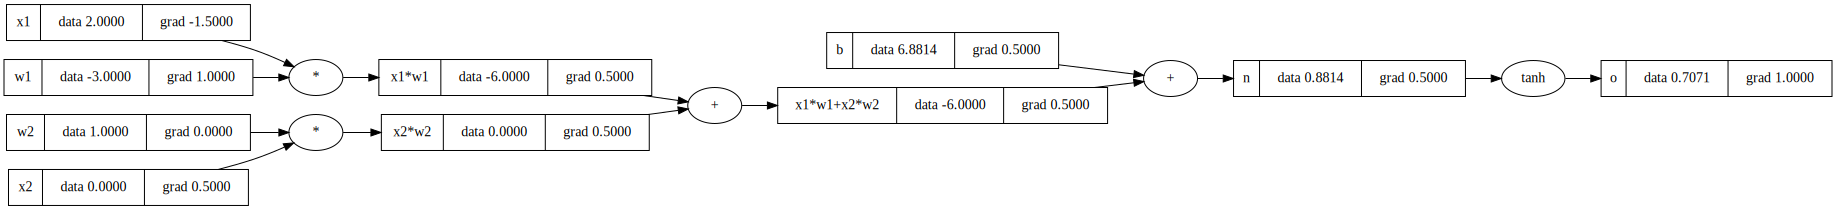

In [24]:
draw_dot(o)

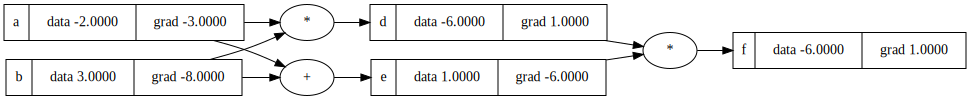

In [27]:
a=Value(-2.0,label='a')
b=Value(3.0,label='b')
d=a*b ; d.label='d'
e=a+b ; e.label='e'
f=d*e ; f.label='f'

f.backward()
draw_dot(f)
